# Combustion Chemistry in Isobaric Reactor: Postprocessing DeepONet

In [1]:
### Importing Libraries

import sys
print(sys.version)
import os
import time


### Defining WORKSPACE_PATH

# WORKSPACE_PATH = os.environ['WORKSPACE_PATH']
WORKSPACE_PATH = os.path.join(os.getcwd(), '../../../../../../')
ROMNet_fld     = os.path.join(WORKSPACE_PATH, 'ROMNet/romnet/')


### Importing External Libraries

import numpy                             as np
import pandas                            as pd
from   numpy                         import diff
import                           cantera as ct

### Importing Matplotlib and Its Style

import matplotlib.pyplot                 as plt

#plt.style.use(os.path.join(WORKSPACE_PATH, 'ROMNet/romnet/extra/postprocessing/presentation.mplstyle'))
#plt.style.use(os.path.join(WORKSPACE_PATH, 'ROMNet/romnet/extra/postprocessing/zoomed.mplstyle'))
plt.style.use(os.path.join(WORKSPACE_PATH, 'ROMNet/romnet/extra/postprocessing/paper_1column.mplstyle'))
#plt.style.use(os.path.join(WORKSPACE_PATH, 'ROMNet/romnet/extra/postprocessing/paper_2columns.mplstyle'))


from scipy.integrate import solve_ivp
import pyDOE
from PCAfold         import PCA          as PCAA


import romnet                            as rmnt


# from IPython.core.display import display, HTML
# display(HTML("<style>.container { width:80% !important; }</style>"))

3.8.11 (default, Jun 29 2021, 03:17:05) 
[Clang 12.0.0 (clang-1200.0.32.29)]


Missing colon in file PosixPath('/Users/sventur/.matplotlib/stylelib/paper_2columns.mplstyle'), line 1 ('f#### MATPLOTLIBRC FORMAT')


In [2]:
DataDir          = os.path.join(WORKSPACE_PATH, 'ROMNet/Data/StiffKinetics_500Cases/')

path_to_run_fld  = os.path.join(WORKSPACE_PATH, 'ROMNet/StiffKinetics_500Cases/DeepONet/Run_20/')

FigDir           = os.path.join(WORKSPACE_PATH, '../Desktop/Paper_Figures_DeepONet_TEMP/')


DataType         = 'train'
CasesVec         = range(0,500,100)
# DataType         = 'test'
# CasesVec         = range(10) #[1,0,2]



NSamples         = 1

FixedMinVal      = 1.e-14 

PCA_NAME         = 'All'

scale            = 'lin'
MinVal           = 1.e-40

 
ColorVec         = ['#190707', '#dd3232', '#0065a9', '#348a00','#985396','#f68b69']
LineVec          = ['-',':','--','.-']*10

## Loading ROMNet's Input Data File

In [3]:
print("\n[ROMNet]: Reading Input File from: ", path_to_run_fld)
sys.path.insert(0, path_to_run_fld)

print("\n[ROMNet]: Keep Loading Modules and Functions...")
from ROMNet_Input import inputdata

print("\n[ROMNet]: Initializing Input ...")
InputData               = inputdata(WORKSPACE_PATH)


InputData.InputFilePath = path_to_run_fld+'/ROMNet_Input.py'
InputData.train_int_flg = 0
InputData.path_to_run_fld  = path_to_run_fld


[ROMNet]: Reading Input File from:  /Users/sventur/WORKSPACE/ROMNet/romnet/scripts/postprocessing/StiffKinetics/DeepONet/../../../../../../ROMNet/StiffKinetics_500Cases/DeepONet/Run_20/

[ROMNet]: Keep Loading Modules and Functions...

[ROMNet]: Initializing Input ...


## Loading Tensorflow's Model for the Network 

In [4]:
surrogate_type = InputData.surrogate_type
if (surrogate_type == 'FNN-SourceTerms'):
    surrogate_type = 'FNN'

Net   = getattr(rmnt.nn, surrogate_type)

model = rmnt.model.Model_TF(InputData)

if (InputData.phys_system is not None):
    System = getattr(rmnt.pinn.system, InputData.phys_system)
    system = System(InputData)
    
model.build(InputData, None, Net, system)#, loadfile_no='000027')

NN    = model.net


[ROMNet - model_tf.py    ]:   Initializing the ML Model

[ROMNet - model_tf.py    ]:   Building the ML Model

[ROMNet - deeponet.py               ]:   Constructing Deep Operator Network: 
[ROMNet - system_of_components.py   ]:     Mapping Branch-to-Trunk (i.e., self.branch_to_trunk Object):  [0 1 2]
[ROMNet - system_of_components.py   ]:     Constructing System of Components: DeepONet
[ROMNet - component.py              ]:       Constructing Component: Branch_1
[ROMNet - sub_component.py          ]:         Constructed Sub-Component: Main with Layers:       ListWrapper([<romnet.nn.building_blocks.normalization.CustomNormalization object at 0x15e0c2c70>, <keras.layers.core.dense.Dense object at 0x15e38f220>, <keras.layers.core.dense.Dense object at 0x15e3658e0>, <keras.layers.core.dense.Dense object at 0x15e365880>, <keras.layers.core.dense.Dense object at 0x15e38f190>])
[ROMNet - component.py              ]:       Constructing Component: Branch_2
[ROMNet - sub_component.py          ]:


[ROMNet - model_tf.py    ]:   Saving ML Model Parameters to File:  /Users/sventur/WORKSPACE/ROMNet/romnet/scripts/postprocessing/StiffKinetics/DeepONet/../../../../../../ROMNet/StiffKinetics_500Cases/DeepONet/Run_20//Model/Params/Initial.h5
'save_params' took 0.092806 s

'build' took 6.069433 s



## Evaluating DeepONet on Test Data

### ODE

In [5]:
def fOrig(t, y):
    return [-Params[0]*y[0] + Params[2]*y[1]*y[2], 
             Params[0]*y[0] - Params[1]*y[1]**2 - Params[2]*y[1]*y[2],
             Params[1]*y[1]**2]

Params = np.array([0.04, 3.e7, 1e4], dtype=np.float64)

### Loading Variables Info

In [6]:
Vars  = ['s1', 's2', 's3']

Vars0 = []
for Var in Vars:
    Vars0.append(str(Var)+'0')
    
InputVars = Vars0+['t']

In [7]:
### From Latin Hypercube 
n_training = 500
n_test     = 50

y0Mat      = np.zeros((n_training,3))
y0Mat[:,0] = np.random.rand(n_training)*0.9999
y0Mat[:,2] = np.random.rand(n_training)*1.e-4
y0Mat[:,1] = 1. - (y0Mat[:,0]+y0Mat[:,2])

y0MatTest      = np.zeros((n_test,3))
y0MatTest[:,0] = np.random.rand(n_test)*0.9999
y0MatTest[:,2] = np.random.rand(n_test)*1.e-4
y0MatTest[:,1] = 1. - (y0MatTest[:,0]+y0MatTest[:,2])

### Loading and Plotting Test/Training Data

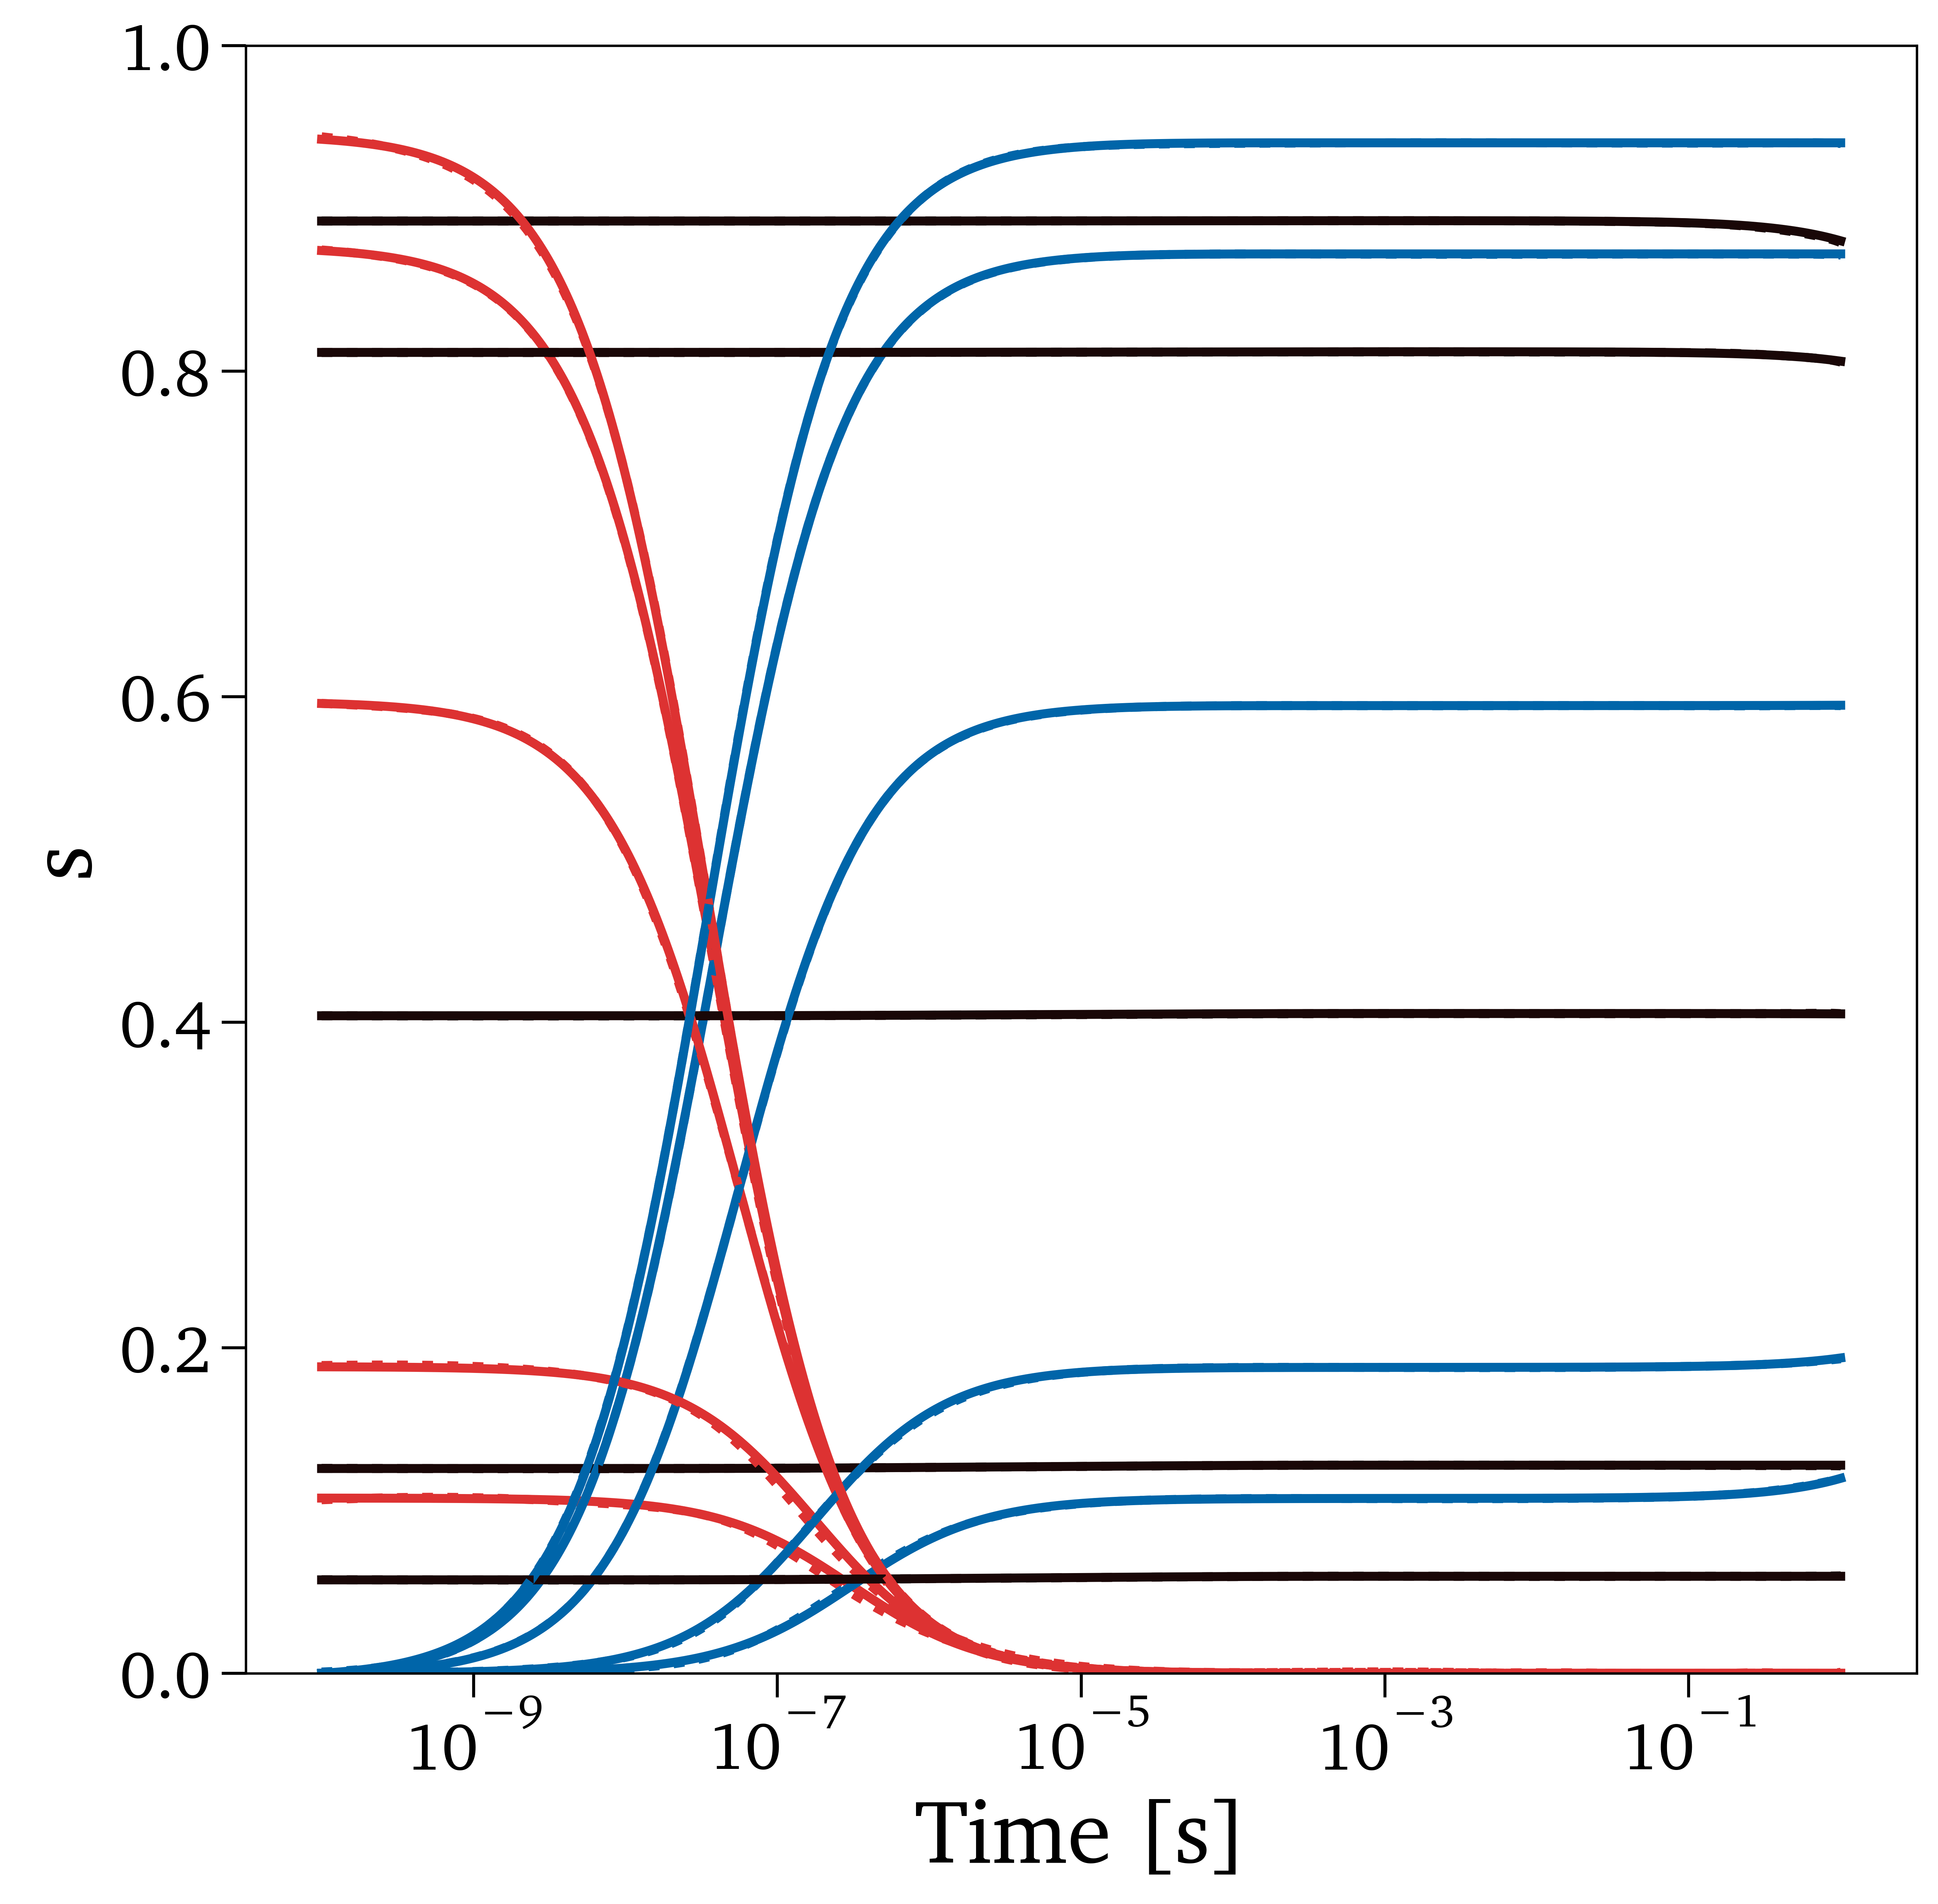

In [11]:
Nt          = 1000
tout        = np.logspace(-10,0,Nt)

fig   = plt.figure()
jTest = 0
for iTest in CasesVec:
    y0         = y0Mat[iTest,:]
    #y0         = [1.,0.,0.]
    
    output     = solve_ivp( fOrig, tout[[0,-1]], y0, method='Radau', t_eval=tout, rtol=1.e-12, atol=1.e-12 )
    plt.plot(output.t, output.y[0,:], color=ColorVec[0])
    plt.plot(output.t, output.y[1,:], color=ColorVec[1])
    plt.plot(output.t, output.y[2,:], color=ColorVec[2])
    y_Data = output.y.T

        
    Data0            = pd.DataFrame([y0], columns=Vars0)
    Data0            = Data0.loc[Data0.index.repeat(Nt)]
    Data0.columns    = Vars0
    Data0['t']       = tout
    Data0.reset_index(drop=True, inplace=True)
    y_Pred           = model.predict(Data0[InputVars])
    plt.plot(output.t, y_Pred[:,0], ':', color=ColorVec[0])
    plt.plot(output.t, y_Pred[:,1], ':', color=ColorVec[1])
    plt.plot(output.t, y_Pred[:,2], ':', color=ColorVec[2])
    
    
    if (jTest == 0):   
        MSE  = (y_Pred[1::] - y_Data[1::])**2#/y_Data[1::]**2
    else:
        MSE += (y_Pred[1::] - y_Data[1::])**2#/y_Data[1::]**2
        
    jTest += 1
    
    
plt.xscale('log')
#plt.yscale('log')
plt.xlabel('Time [s]')
plt.ylabel('s')
plt.ylim([0.,1.])

if (FigDir):
    plt.savefig(FigDir+'/StiffKinetics_DeepONet.eps', format='eps', bbox_inches='tight')

In [9]:
RMSE = np.sqrt( MSE.sum(axis=0) / (len(CasesVec) * MSE.shape[0]) )
print('Root Mean Squared Error = ', RMSE)

Root Mean Squared Error =  [9.70198839e-05 1.08739898e-03 3.19447308e-04]


## Plotting Loss Histories

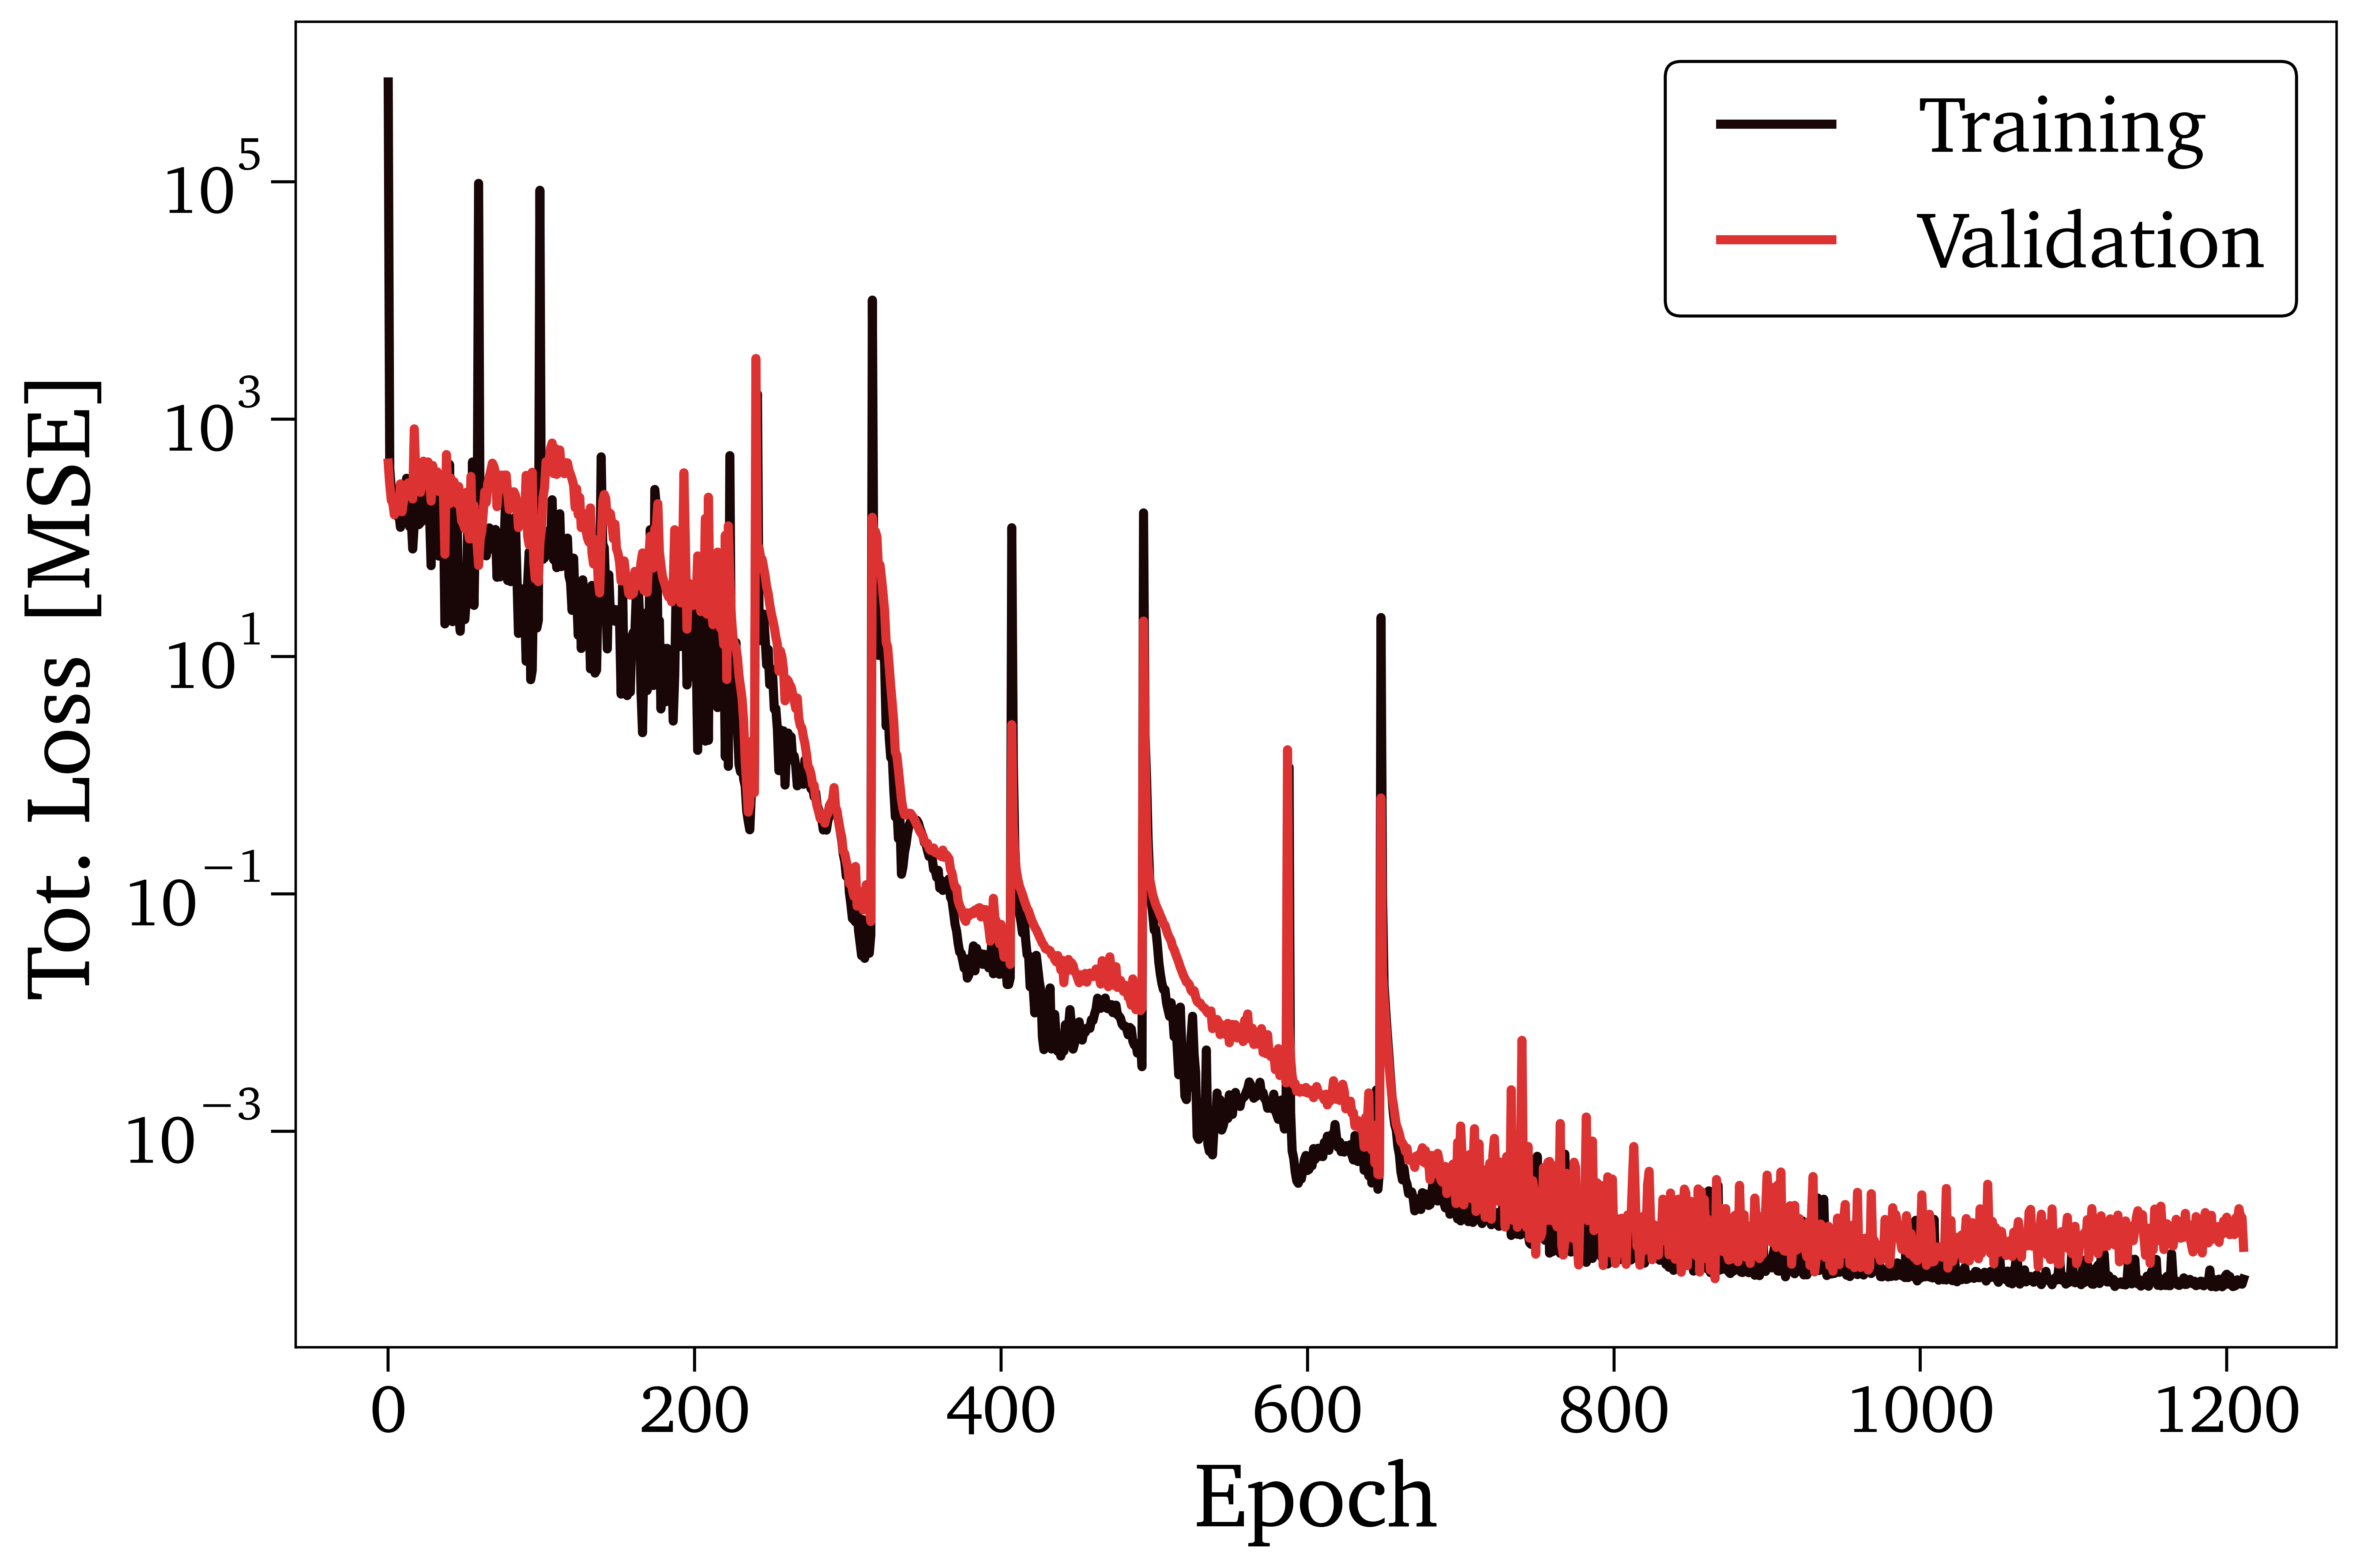

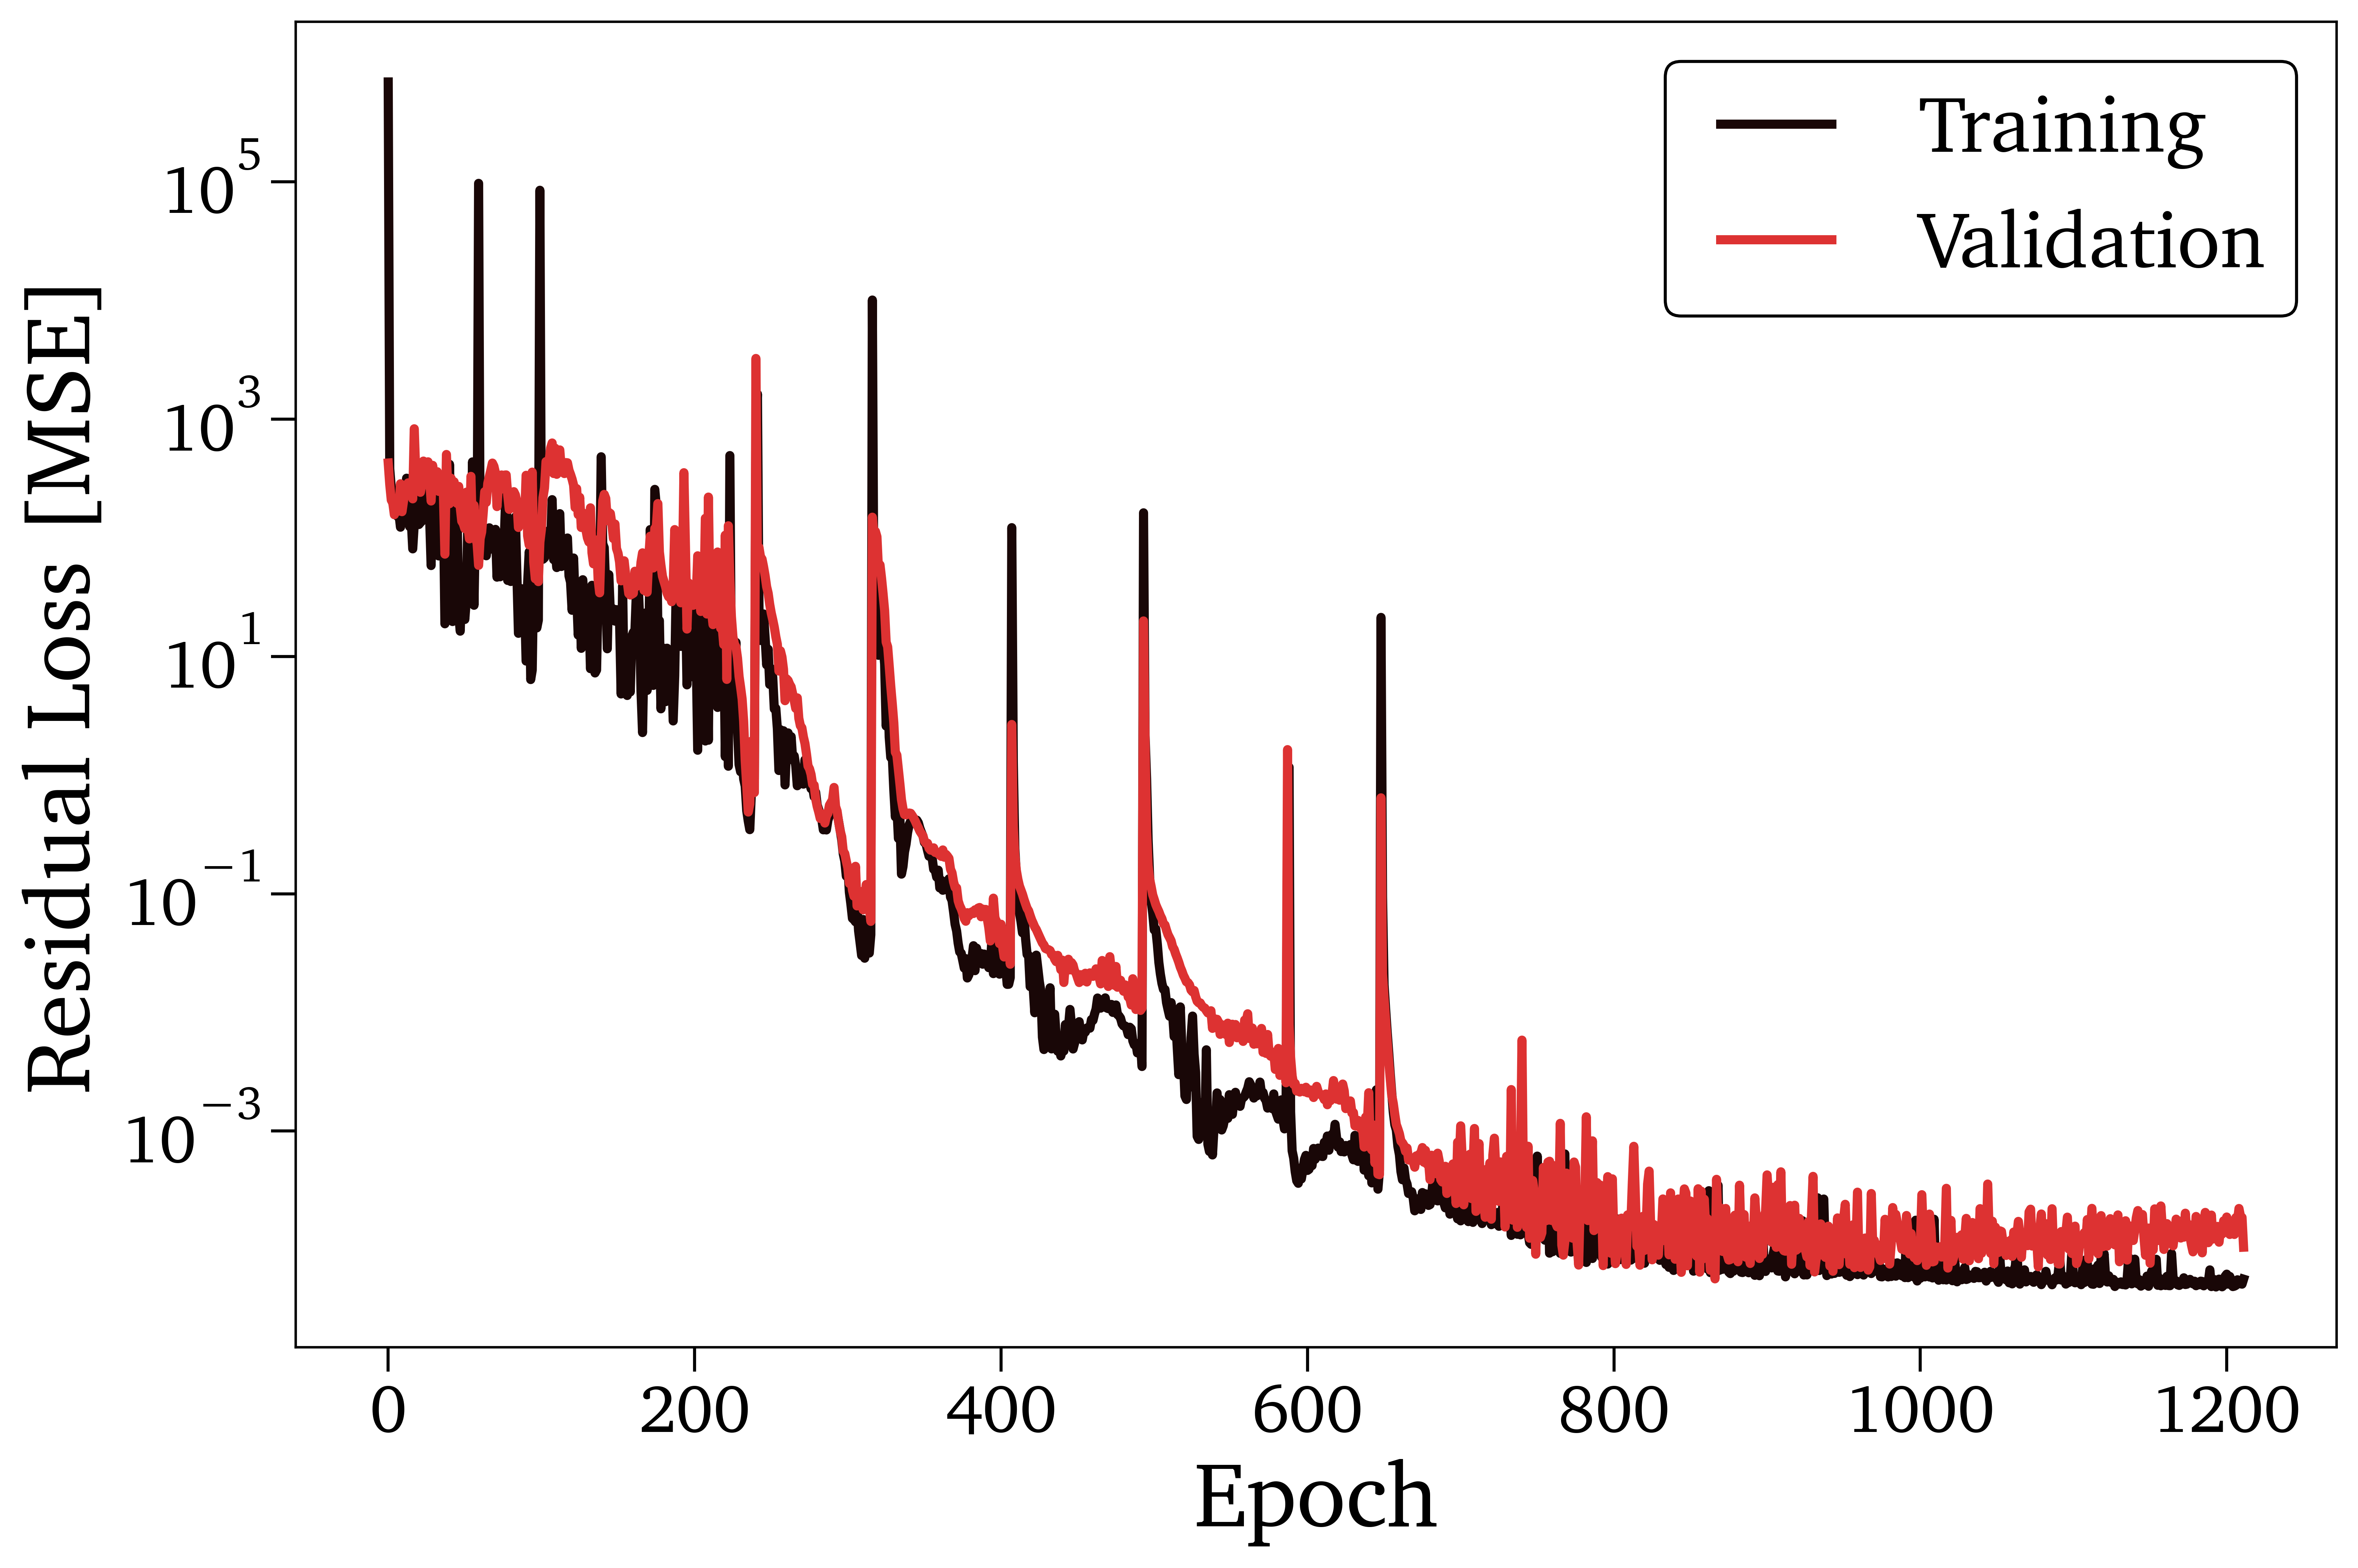

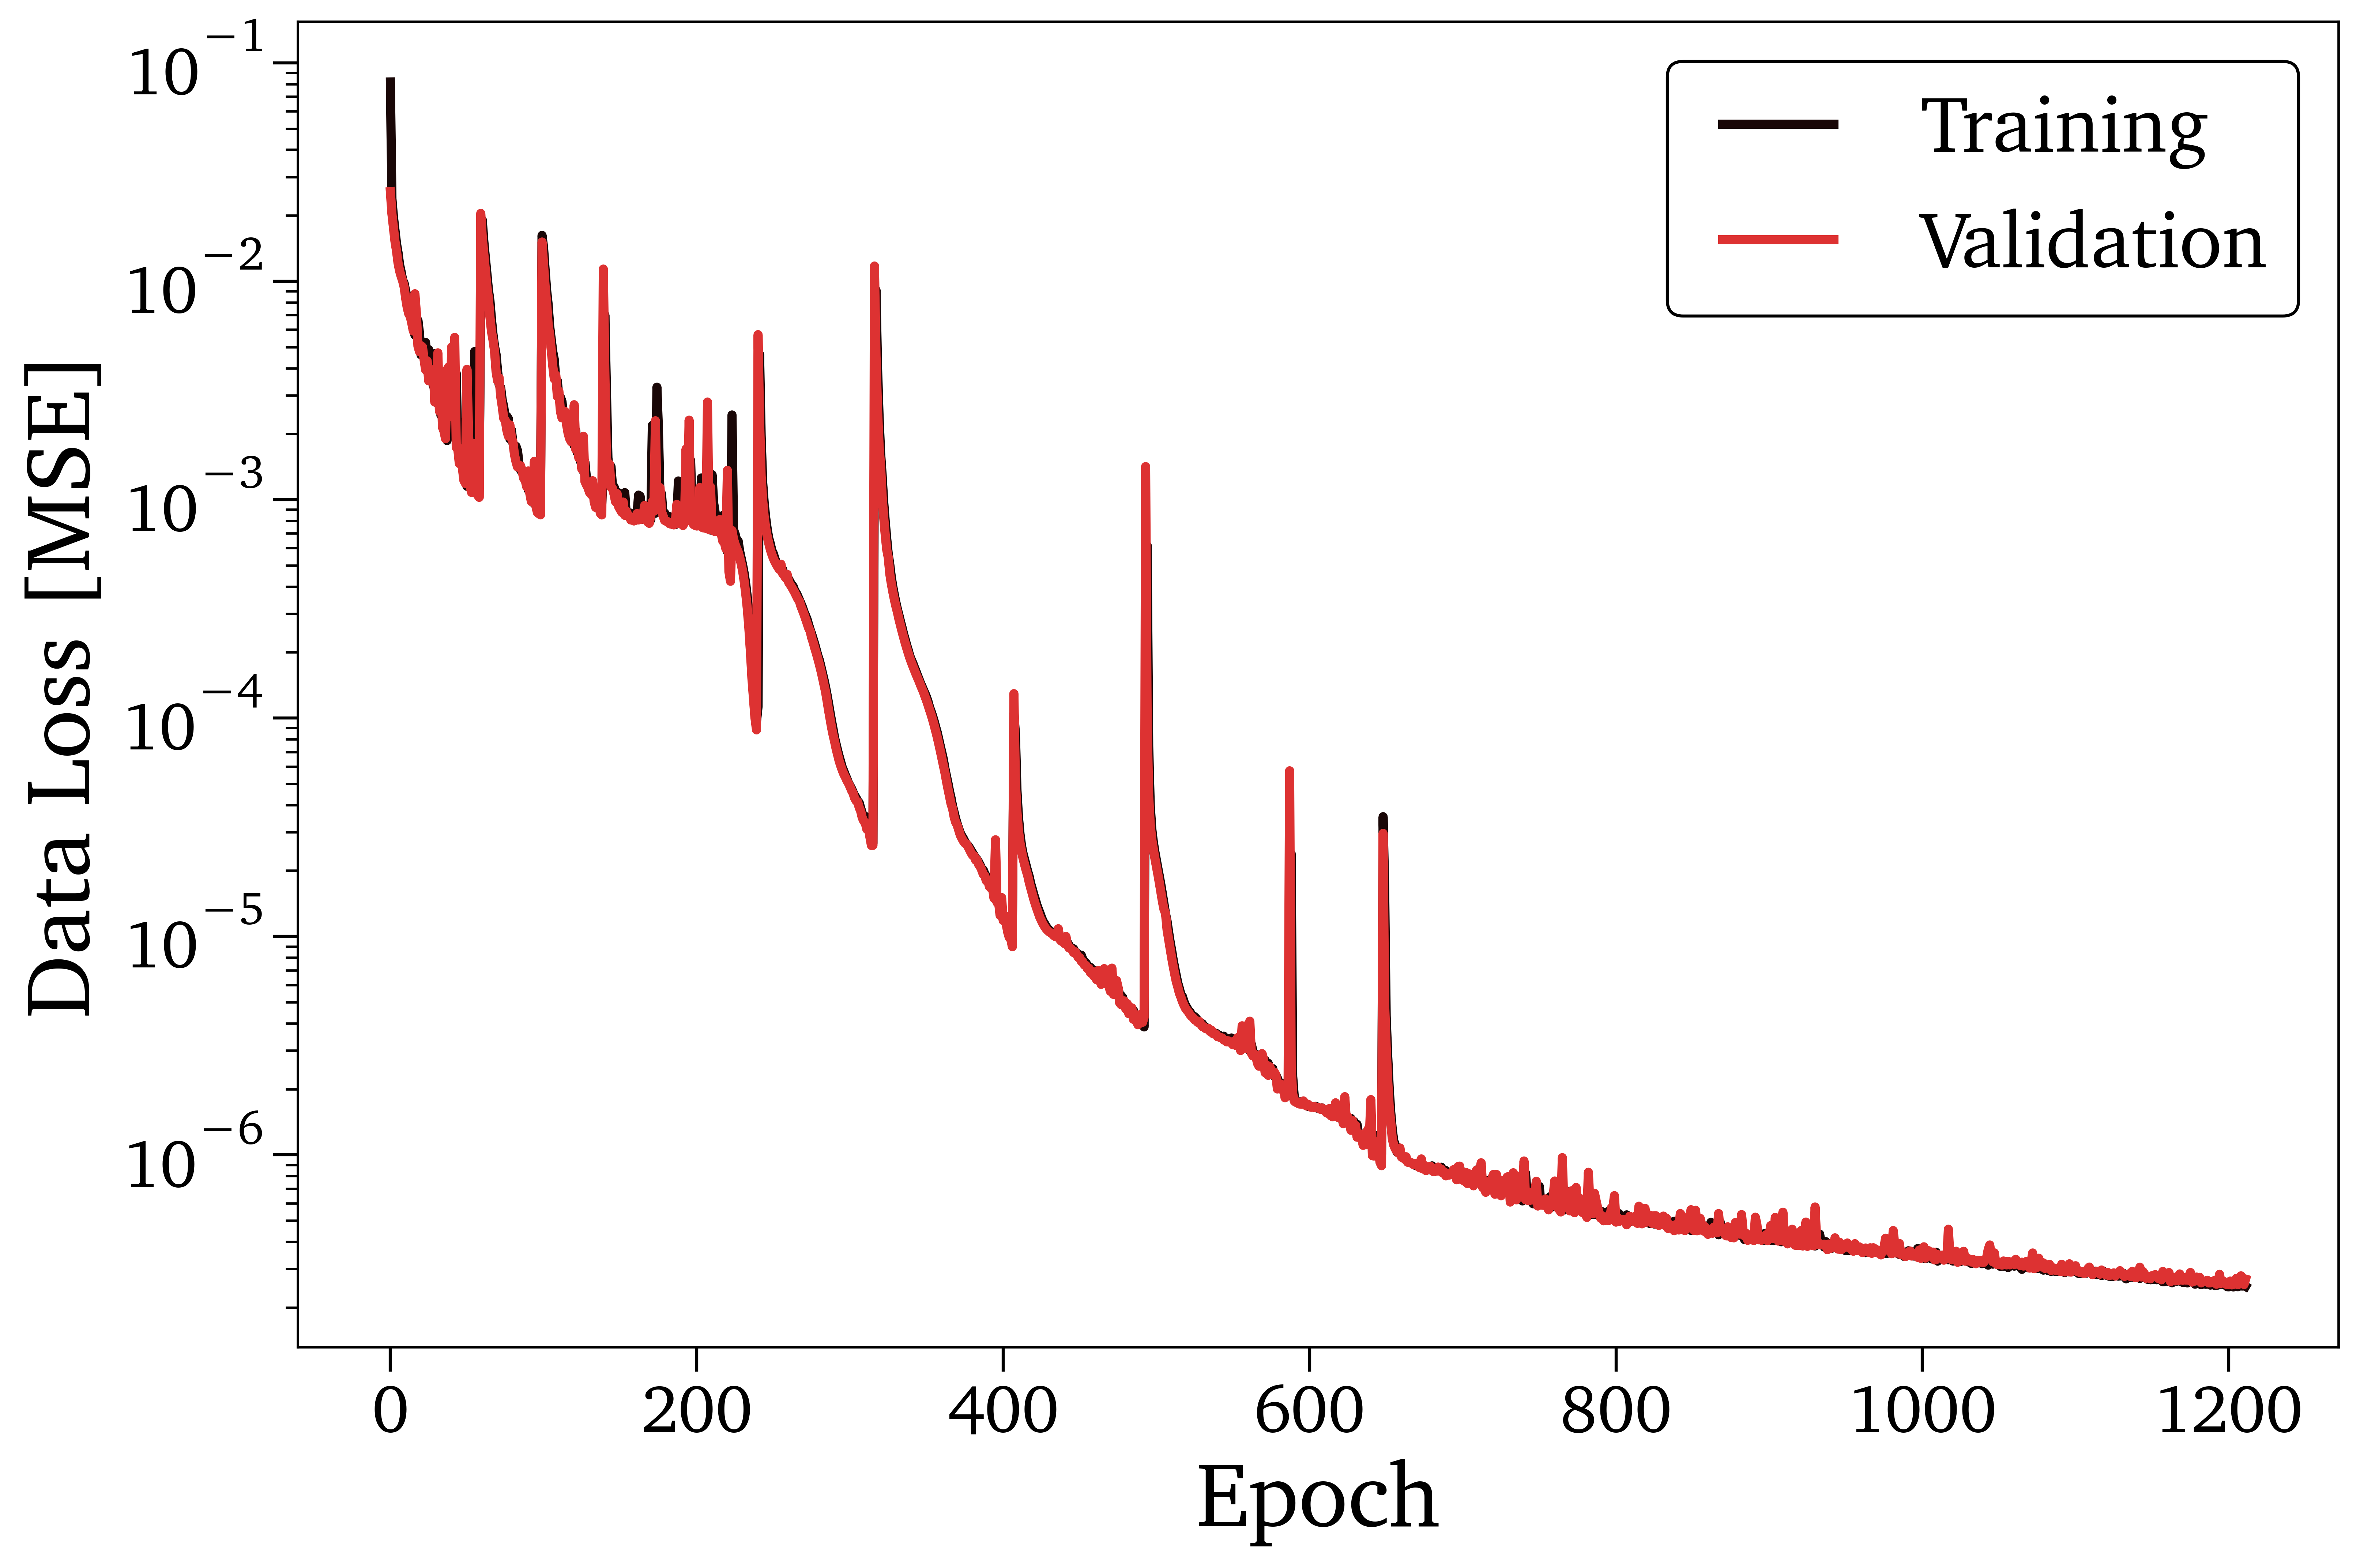

In [12]:
Data = pd.read_csv(path_to_run_fld+'/Training/History.csv')

fig  = plt.figure(figsize=(12,8))
plt.plot(Data['tot_loss'],     label='Training')
plt.plot(Data['val_tot_loss'], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Tot. Loss [MSE]')
plt.legend()
plt.yscale('log')

fig  = plt.figure(figsize=(12,8))
plt.plot(Data['res_loss'],     label='Training')
plt.plot(Data['val_res_loss'], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Residual Loss [MSE]')
plt.legend()
plt.yscale('log')


fig  = plt.figure(figsize=(12,8))
plt.plot(Data['pts_loss'],     label='Training')
plt.plot(Data['val_pts_loss'], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Data Loss [MSE]')
plt.legend()
plt.yscale('log')

# fig  = plt.figure(figsize=(12,8))
# plt.plot(Data['scs_loss'],     label='Training')
# plt.plot(Data['val_scs_loss'], label='Validation')
# plt.xlabel('Epoch')
# plt.ylabel('S.C.s Loss [MSE]')
# plt.legend()
# plt.yscale('log')

# fig  = plt.figure(figsize=(12,8))
# plt.plot(Data['ics_loss'],     label='Training')
# plt.plot(Data['val_ics_loss'], label='Validation')
# plt.xlabel('Epoch')


# plt.ylabel('I.C.s Loss [MSE]')
# plt.legend()
# plt.yscale('log')